#### 使用适应性耦合强度，两层网络中实现同步的爆炸同步
ref : X. Zhang, et al. Explosive Synchronization in Adaptive and Multilayer Networks, Phys. Rev. Lett. 114, 038701 (2015).

model: Kuramoto model

network: ER network 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import random
import networkx as nx
from scipy.sparse import coo_matrix
import scipy.sparse as sp
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)

##### 算法模型

In [3]:
# Kuramoto 模型
@njit
def kuramoto(vars, t, omega, c, pre_ids, post_ids):
    """
    Kuramoto 模型的微分方程。
    args:
        vars: 相位
        t: 当前时间
        omega: 自然频率
        c: 耦合强度
    """
    currents = np.sin(vars[pre_ids]- vars[post_ids])

    num_nodes = len(vars)
    
    I_couple = np.bincount(post_ids, weights=currents, minlength=num_nodes)

    dvars_dt = omega + c * I_couple

    return dvars_dt

@njit
def RK4(fun, x0, t, dt, *args):
    """
    使用 Runge-Kutta 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程
        x0: 上一个时间单位的状态变量
        t: 运行时间
        dt: 时间步长
    :return:
        x0 (numpy.ndarray): 下一个时间单位的状态变量
    """
    k1 = fun(x0, t, *args)
    k2 = fun(x0 + (dt / 2.) * k1, t + (dt / 2.), *args)
    k3 = fun(x0 + (dt / 2.) * k2, t + (dt / 2.), *args)
    k4 = fun(x0 + dt * k3, t + dt, *args)

    x0 += (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

@njit
def Heun(fun, x0, t, dt, *args):
    """
    使用 Heun 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程函数，形式为 fun(x, t, *args)
        x0: 上一个时间单位的状态变量 (numpy.ndarray)
        t: 当前时间
        dt: 时间步长
    return:
        x1 (numpy.ndarray): 下一个时间单位的状态变量
    """
    # 计算当前点的斜率
    k1 = fun(x0, t, *args)
    
    # 使用 Euler 法预测值
    x_pred = x0 + dt * k1
    
    # 在预测点上计算新的斜率
    k2 = fun(x_pred, t + dt, *args)
    
    # 加权平均斜率得到新的状态
    x0 += 0.5 * dt * (k1 + k2)
    return x0

In [4]:
method = Heun

##### 统计量

In [5]:
@njit
def order_parameter(vars):
    """
    计算系统的序参量。
    args:
        vars: 相位
    return:
        r (float): 序参量
    """
    N = len(vars)
    r = np.abs(np.sum(np.exp(1j * vars)) / N)
    return r

@njit
def local_order_parameter(vars, pre_ids, post_ids, degree_lit):
    """
    计算系统的局部序参量。
    args:
        vars: 相位
        pre_ids: 前节点id
        post_ids: 后节点id
        degree_lit: 节点度
    return:
        r (float): 局部序参量
    """
    N = len(vars)

    # 计算复指数
    r_temp = np.exp(1j * vars[pre_ids])

    # 分别处理实部和虚部
    real_part = r_temp.real
    imag_part = r_temp.imag

    # 使用 np.bincount 分别计算实部和虚部的累加
    sum_real = np.bincount(post_ids, weights=real_part, minlength=N)
    sum_imag = np.bincount(post_ids, weights=imag_part, minlength=N)

    # 合并为复数
    # r_sum = sum_real + 1j * sum_imag
    r_sum_abs = np.sqrt(sum_real**2 + sum_imag**2)
    
    r_local = r_sum_abs / degree_lit

    return r_local

In [6]:
# 创建网络
@njit
def net_2layer(N, A_adj1, A_adj2, w_list):
    # =================== 节点参数 ===================
    # 自然频率
    omega1 = np.random.uniform(-1., 1., N)  # 1-layer
    omega2 = np.random.uniform(-1., 1., N)  # 2-layer
    # 初始相位
    vars_nodes1 = np.random.uniform(-np.pi, np.pi, N)  # 1-layer
    vars_nodes2 = np.random.uniform(-np.pi, np.pi, N)  # 2-layer

    dt = 0.05

    # =================== 网络参数 ===================
    post1_ids, pre1_ids = np.nonzero(A_adj1)  # 1-layer
    post2_ids, pre2_ids = np.nonzero(A_adj2)  # 2-layer

    degrees1 = A_adj1.sum(axis=1)
    degrees2 = A_adj2.sum(axis=1)
    
    # 自适应节点设定
    f_adaptive = 1.
    N_adaptive = int(f_adaptive*N)
    idx1 = np.arange(N)
    idx2 = np.arange(N)
    np.random.shuffle(idx1)
    np.random.shuffle(idx2)
    Nodes1_adaptive = np.sort(idx1[:N_adaptive])
    Nodes2_adaptive = np.sort(idx2[:N_adaptive])

    r1_list = []
    r2_list = []
    for w in w_list:

        # 初始化权重
        weights1 = w * np.ones(N)
        weights2 = w * np.ones(N)

        t = 0.

        # 初始化(网络)
        for i in range(200_00):
            r_local1 = local_order_parameter(vars_nodes1, pre1_ids, post1_ids, degrees1)
            r_local2 = local_order_parameter(vars_nodes2, pre2_ids, post2_ids, degrees2)

            weights1[Nodes1_adaptive] = w * r_local1[Nodes1_adaptive]
            weights2[Nodes2_adaptive] = w * r_local2[Nodes2_adaptive]

            method(kuramoto, vars_nodes1, t, dt, omega1, weights2, pre1_ids, post1_ids)
            method(kuramoto, vars_nodes2, t, dt, omega2, weights1, pre2_ids, post2_ids)

        # =================== 计算 ===================
        r1 = 0.
        r2 = 0.
        cal_n = 1000_00
        for i in range(cal_n):
            r_local1 = local_order_parameter(vars_nodes1, pre1_ids, post1_ids, degrees1)
            r_local2 = local_order_parameter(vars_nodes2, pre2_ids, post2_ids, degrees2)

            weights1[Nodes1_adaptive] = w * r_local1[Nodes1_adaptive]
            weights2[Nodes2_adaptive] = w * r_local2[Nodes2_adaptive]

            method(kuramoto, vars_nodes1, t, dt, omega1, weights2, pre1_ids, post1_ids)
            method(kuramoto, vars_nodes2, t, dt, omega2, weights1, pre2_ids, post2_ids)

            t += dt
            r1 += order_parameter(vars_nodes1)/cal_n
            r2 += order_parameter(vars_nodes2)/cal_n

        r1_list.append(r1)
        r2_list.append(r2)
        
    # print(r1_list, r2_list)

    return r1_list, r2_list

In [ ]:
@njit(parallel=True)
def Parallel_net(N, A_adj1, A_adj2, weight_list):
    len = weight_list[0].shape[0]
    results1 = np.zeros((2, len))   # 1-layer
    results2 = np.zeros((2, len))   # 2-layer

    for i in prange(2):
        result = net_2layer(N, A_adj1, A_adj2, weight_list[i])
        results1[i] = np.asarray(result[0])
        results2[i] = np.asarray(result[1])

    return results1, results2

In [8]:
N = 1000
m = 12
G1 = nx.gnm_random_graph(N, int(m*N/2))
A_adj1 = nx.to_numpy_array(G1)  # 邻接矩阵

G2 = nx.gnm_random_graph(N, int(m*N/2))
A_adj2 = nx.to_numpy_array(G2)  # 邻接矩阵

In [9]:
w_list1 = np.arange(0., 0.51, 0.01)  # 耦合强度列表
w_list2 = w_list1[::-1].copy()
weight_list = np.asarray([w_list1, w_list2])
# w_list = [0.3]

# r = net_2layer(N, A_adj1, A_adj2, w_list)

In [10]:
results = Parallel_net(N, A_adj1, A_adj2, weight_list)

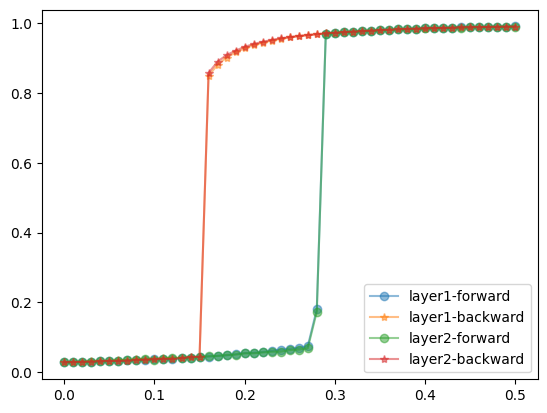

In [12]:
plt.plot(w_list1, results[0][0], 'o-', label='layer1-forward', alpha=0.5)
plt.plot(w_list2, results[0][1], '*-', label='layer1-backward', alpha=0.5)
plt.plot(w_list1, results[1][0], 'o-', label='layer2-forward', alpha=0.5)
plt.plot(w_list2, results[1][1], '*-', label='layer2-backward', alpha=0.5)
plt.legend()
plt.show()